In [ ]:
import numpy as np
import ijson
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from datetime import datetime, timezone, timedelta
from datetime import datetime, timezone, timedelta
from datetime import datetime, timezone, timedelta
# Standard library
from matplotlib.patches import Rectangle
from matplotlib.ticker import FixedLocator
from datetime import timedelta, timezone
import random
import time
import math
import random
import datetime
from datetime import datetime, timedelta, timezone
import warnings

# Third-party libraries
import numpy as np
import ijson
import pandas as pd
import dtale
from shapely.geometry import Polygon
import numpy as np

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FixedLocator
from matplotlib import colors as mcolors
from matplotlib.patches import Polygon as MplPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Shapely
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection

from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union, polygonize
from shapely.geometry import Polygon
from shapely.geometry import Polygon
from shapely.geometry import Polygon
from shapely.geometry import box
# IPython / Widgets (for interactive use)
from ipywidgets import Checkbox, HBox, VBox, HTML
from IPython.display import display
import mplcursors


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon as MplPolygon
from ipywidgets import Checkbox, HBox, VBox, HTML
from IPython.display import display
import matplotlib.colors as mcolors
from datetime import datetime, timedelta, timezone
import numpy as np
import random

# For interactive plots (if needed)


%matplotlib widget

In [158]:


# Constants for Edie cell resolution
DX_FEET = 160  # ~50 meters
DT_SECONDS = 60  # 1-minute time windows

# Convert timestamp to Edie time bin
def time_bin(t, dt):
    return int(t // dt)

# Convert x-position to Edie space bin
def space_bin(x, dx):
    return int(x // dx)

# Create the main parser and Edie statistics accumulator
def compute_edie_stats(file_path, direction=-1, dx=DX_FEET, dt=DT_SECONDS):
    edie_grid = defaultdict(lambda: {"distance": 0.0, "time": 0.0, "count": 0})
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            timestamps = np.array(record["timestamp"])
            x_positions = np.array(record["x_position"])
            if len(timestamps) < 2:
                continue

            if not got_date:
                date = datetime.fromtimestamp(timestamps[0]).date()
                got_date = True

            for i in range(1, len(timestamps)):
                t0, t1 = timestamps[i - 1], timestamps[i]
                x0, x1 = x_positions[i - 1], x_positions[i]

                dt_seg = t1 - t0
                dx_seg = (x1 - x0) * direction
                if dt_seg <= 0 or dx_seg <= 0:
                    continue

                t_bins = list(range(time_bin(t0, dt), time_bin(t1, dt) + 1))
                x_bins = list(range(space_bin(x0, dx), space_bin(x1, dx) + 1))

                # Spread segment contributions to all intersected Edie cells
                for tb in t_bins:
                    for xb in x_bins:
                        edie_grid[(xb, tb)]["distance"] += dx_seg
                        edie_grid[(xb, tb)]["time"] += dt_seg
                        edie_grid[(xb, tb)]["count"] += 1

            count += 1
            if count % 10000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"✅ Finished parsing {count} trajectories.")
    return edie_grid, date



In [159]:
def compute_edie_metrics(edie_grid, dx=DX_FEET, dt=DT_SECONDS):
    edie_metrics = {}

    # Edie cell area in space-time (W_X)
    WX = dx * dt  # feet * seconds

    for (xb, tb), stats in edie_grid.items():
        TD = stats["distance"]  # total distance traveled in feet
        TT = stats["time"]      # total time spent in seconds

        # Edie definitions:
        # Flow q = TD / WX  (vehicles * feet / (feet * seconds) = vehicles / second)
        # Density k = TT / WX  (vehicle-seconds / (feet * seconds) = vehicles / foot)
        # Speed v = TD / TT  (feet / second), if TT > 0

        q = TD / WX if WX > 0 else 0  # flow in veh/sec
        k = TT / WX if WX > 0 else 0  # density in veh/ft
        v = TD / TT if TT > 0 else 0  # speed in ft/sec

        # Optionally convert to more familiar units:
        v_mph = v * 3600 / 5280         # feet/sec -> miles/hour
        k_vpm = k * 5280                # veh/foot -> veh/mile
        q_vph = q * 3600                # veh/sec -> veh/hour

        edie_metrics[(xb, tb)] = {
            "flow_vph": q_vph,
            "density_vpm": k_vpm,
            "speed_mph": v_mph,
            "raw": {
                "TD": TD,
                "TT": TT,
                "WX": WX,
                "flow": q,
                "density": k,
                "speed": v
            }
        }

    return edie_metrics


In [160]:
def visualize_edie_grid(edie_grid, dx=160, dt=60):
    keys = np.array(list(edie_grid.keys()))
    if len(keys) == 0:
        print("No data to visualize.")
        return

    x_bins = keys[:, 0]
    t_bins = keys[:, 1]

    # Create arrays of statistics for each cell
    distances = np.array([edie_grid[key]["distance"] for key in edie_grid])
    times = np.array([edie_grid[key]["time"] for key in edie_grid])
    counts = np.array([edie_grid[key]["count"] for key in edie_grid])

    # Calculate average speed (feet per second)
    avg_speed = np.divide(distances, times, out=np.zeros_like(distances), where=times != 0)

    # Define grid size
    x_min, x_max = x_bins.min(), x_bins.max()
    t_min, t_max = t_bins.min(), t_bins.max()

    width = t_max - t_min + 1
    height = x_max - x_min + 1

    # Create 2D arrays for heatmap
    speed_grid = np.full((height, width), np.nan)

    for (xb, tb), speed in zip(edie_grid.keys(), avg_speed):
        row = xb - x_min  # space
        col = tb - t_min  # time
        speed_grid[row, col] = speed * 3600 / 5280  # ft/s to mph

    # Y-axis: Space in miles
    y_labels = [(x_min + i) * dx / 5280 for i in range(height)]
    y_ticks = np.linspace(0, height - 1, num=min(10, height), dtype=int)

    # X-axis: Time in HH:MM:SS with UTC-6 adjustment
    utc_offset = timedelta(hours=-6)
   # Convert bin index to actual datetime with UTC offset
    x_labels = [
        (datetime.fromtimestamp((t_min + i) * dt) + utc_offset).strftime("%H:%M")
        for i in range(width)
    ]
    x_ticks = np.linspace(0, width - 1, num=min(10, width), dtype=int)


    plt.figure(figsize=(14, 6))
    im = plt.imshow(speed_grid, aspect='auto', origin='upper', cmap='viridis') # orginin upper inverts y-axis since westbound

    plt.colorbar(im, label='Average Speed (mph)')
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks], rotation=45)
    plt.yticks(y_ticks, [f"{y_labels[i]:.1f}" for i in y_ticks])

    plt.xlabel('Time (UTC-6)')
    plt.ylabel('Space (Miles)')
    plt.title('Edie Grid: Average Speed Heatmap')
    plt.tight_layout()
    plt.show()


In [161]:
edie_cells, date = compute_edie_stats(
    file_path="/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",  # replace with actual file path
    dx=160,        # 160 feet ≈ ~50 meters
    dt=30,         # 60 seconds time resolution
    direction=-1   # set the correct traffic direction
)



Processed 10000 trajectories...
Processed 20000 trajectories...
Processed 30000 trajectories...
Processed 40000 trajectories...
Processed 50000 trajectories...
Processed 60000 trajectories...
Processed 70000 trajectories...
Processed 80000 trajectories...
Processed 90000 trajectories...
Processed 100000 trajectories...
Processed 110000 trajectories...
Processed 120000 trajectories...
Processed 130000 trajectories...
Processed 140000 trajectories...
Processed 150000 trajectories...
Processed 160000 trajectories...
Processed 170000 trajectories...
Processed 180000 trajectories...
Processed 190000 trajectories...
Processed 200000 trajectories...
Processed 210000 trajectories...
Processed 220000 trajectories...
Processed 230000 trajectories...
Processed 240000 trajectories...
Processed 250000 trajectories...
Processed 260000 trajectories...
Processed 270000 trajectories...
Processed 280000 trajectories...
Processed 290000 trajectories...
Processed 300000 trajectories...
Processed 310000 tr

In [ ]:


# Pick a random key from the dictionary
random_key = random.choice(list(edie_cells.keys()))

# Print the key and its corresponding value
print("Random Edie Cell Key:", random_key)
print("Cell Stats:", edie_cells[random_key])

Random Edie Cell Key: (1942, 55634555)
Cell Stats: {'distance': 5629.857229721674, 'time': 53.92000150680542, 'count': 1348}


In [163]:
compute_edie_metrics(edie_cells,dx=160, dt=30)

{(2041, 55634400): {'flow_vph': 438.8598951502063,
  'density_vpm': 6.512000346183777,
  'speed_mph': 67.3924864588484,
  'raw': {'TD': 585.1465268669417,
   'TT': 5.920000314712524,
   'WX': 4800,
   'flow': 0.12190552643061285,
   'density': 0.0012333333988984426,
   'speed': 98.84231347297765}},
 (1949, 55634399): {'flow_vph': 4.585416183195775,
  'density_vpm': 0.13200013637542723,
  'speed_mph': 34.73796549841583,
  'raw': {'TD': 6.113888244261034,
   'TT': 0.12000012397766113,
   'WX': 4800,
   'flow': 0.001273726717554382,
   'density': 2.5000025828679403e-05,
   'speed': 50.94901606434321}},
 (1949, 55634400): {'flow_vph': 2037.8452117733978,
  'density_vpm': 31.284000849723817,
  'speed_mph': 65.1401724978341,
  'raw': {'TD': 2717.126949031197,
   'TT': 28.440000772476196,
   'WX': 4800,
   'flow': 0.5660681143814994,
   'density': 0.005925000160932541,
   'speed': 95.53891966349}},
 (1948, 55634400): {'flow_vph': 1951.5954020446516,
  'density_vpm': 29.34800033569336,
  'spee

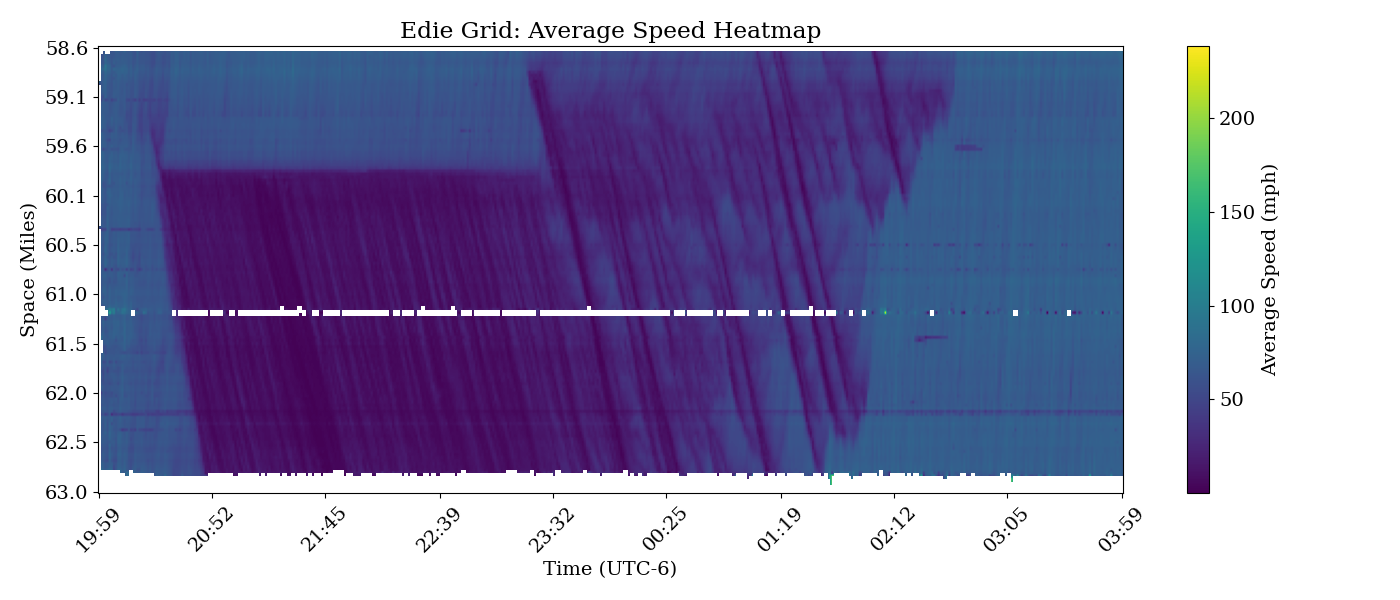

In [164]:
visualize_edie_grid(edie_cells)

In [ ]:

def get_left_edge_slope(polygon, debug=False):
    """
    Calculate the slope of the left edge of a rectangle polygon in miles per hour (mph).
    Assumes:
      - x = Unix time (seconds)
      - y = distance in feet
    """
    coords = list(polygon.exterior.coords)

    if coords[0] == coords[-1]:
        coords = coords[:-1]

    if len(coords) != 4:
        raise ValueError("Expected a rectangle with 4 corners.")

    left_points = sorted(coords, key=lambda p: p[0])[:2]
    top = min(left_points, key=lambda p: p[1])
    bottom = max(left_points, key=lambda p: p[1])

    dx_seconds = bottom[0] - top[0]
    dy_feet = bottom[1] - top[1]

    # Avoid divide-by-zero or tiny time deltas
    if dx_seconds < 1e-2:
        return float('inf')

    dy_miles = dy_feet / 5280
    dx_hours = dx_seconds / 3600
    slope_mph = dy_miles / dx_hours

    if debug:
        print(f"Top: {top}, Bottom: {bottom}")
        print(f"dx: {dx_seconds:.2f} sec, dy: {dy_feet:.2f} ft, slope: {slope_mph:.2f} mph")

    return slope_mph





def get_time_length_top_edge(polygon):
    """
    Extracts the top edge (lowest y-values) of a rectangular polygon,
    and calculates the time span (x-direction) between those points.

    Returns:
        dict with:
          - start_ts, end_ts, duration_sec
          - start_str, end_str, duration_str
    """
    coords = list(polygon.exterior.coords)

    # Remove closing point if present (shapely auto-closes polygons)
    if coords[0] == coords[-1]:
        coords = coords[:-1]

    if len(coords) != 4:
        raise ValueError(f"Polygon does not have 4 sides: got {len(coords)}")

    # Find the two points with the lowest y values (top edge in plot)
    top_points = sorted(coords, key=lambda p: p[1])[:2]

    # Determine left/right by comparing x
    top_left = min(top_points, key=lambda p: p[0])
    top_right = max(top_points, key=lambda p: p[0])

    start_ts = top_left[0]
    end_ts = top_right[0]
    duration_sec = end_ts - start_ts

    # Format timestamps
    tz = timezone(timedelta(hours=-6))
    start_str = datetime.fromtimestamp(start_ts, tz=tz).strftime("%H:%M:%S")
    end_str = datetime.fromtimestamp(end_ts, tz=tz).strftime("%H:%M:%S")

    # Duration as H:MM:SS
    duration_td = timedelta(seconds=duration_sec)
    hours, remainder = divmod(int(duration_td.total_seconds()), 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{hours}:{minutes:02d}:{seconds:02d}"

    return {
        "start_ts": start_ts,
        "end_ts": end_ts,
        "duration_sec": duration_sec,
        "start_str": start_str,
        "end_str": end_str,
        "duration_str": duration_str,
    }


def interactive_plot_congestion_with_edie(trajectories, edie_grid, polygons_by_label, dx=160, dt=30):

    # 🎨 Colors
    label_colors = {
        'light_sub_20': "#04ff00",
        'heavy_sub_10': "#ff0000",
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot all trajectories
    all_timestamps, all_positions, all_speeds = [], [], []
    for traj in trajectories:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1, alpha=0.3)
    #plt.colorbar(im, label='Speed (mph)', pad=0.01)


    # Before the Edie cells loop, set up the colormap and normalization:
    norm = Normalize(vmin=0, vmax=55)  # speed range mph
    sm = ScalarMappable(cmap=green_to_red, norm=norm)
    sm.set_array([])  # Required for colorbar, even if empty
    # Plot Edie cells as semi-transparent rectangles
    for (x_bin, t_bin), cell in edie_grid.items():
        distance = cell["distance"]
        time = cell["time"]

        if time == 0:
            continue

        speed = distance / time  # ft/s
        speed_mph = speed * 3600 / 5280

        speed_for_color = min(speed_mph, 55)  # clamp at 55 mph max for color
        color = green_to_red(norm(speed_for_color))

        # Convert to same coordinates as plot
        x0 = x_bin * dx / 5280
        x1 = (x_bin + 1) * dx / 5280

        t_start = t_bin * dt
        t_end = (t_bin + 1) * dt

        rect = Rectangle((t_start, x0), t_end - t_start, x1 - x0,
                         facecolor=color, edgecolor='none', alpha=1, zorder=0)
        ax.add_patch(rect)

    plt.colorbar(sm, ax=ax, label='Speed (mph)', pad=0.01)
    # Format x-axis
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ticks_loc)
    labels = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))).strftime('%H:%M:%S') for ts in ticks_loc]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile Marker")
    ax.invert_yaxis()

    # Hover coordinate format
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # Plot polygons with toggles
    polygon_patches = {}
    toggles = []

    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        shapes = polygons if isinstance(polygons, list) else list(polygons.geoms) if hasattr(polygons, "geoms") else [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    def update_display(change=None):
        for label, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for _, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    update_display()

    display(VBox(toggles))
    plt.tight_layout()
    plt.show()



def union_parallelograms(parallelograms):
    print("🔁 Unioning parallelograms...")
    t0 = time.time()
    merged = unary_union(parallelograms)
    t1 = time.time()
    print(f"✅ Union complete in {t1 - t0:.2f} seconds.")
    return merged



def create_tilted_parallelogram(x, t, speed, length=200, time_span=60):
    """
    Create a parallelogram centered at (x, t), tilted according to speed.
    - x in feet, t in seconds
    - speed in mph
    """
    mph_to_ftps = 1.46667
    slope = speed * mph_to_ftps  # ft/s
    
    half_len = length / 2
    half_time = time_span / 2
    
    # Compute corners with tilt
    corners = [
        (t - half_time, x - slope * half_time - half_len),
        (t - half_time, x - slope * half_time + half_len),
        (t + half_time, x + slope * half_time + half_len),
        (t + half_time, x + slope * half_time - half_len),
    ]
    return Polygon(corners)



def split_by_thin_connections(polygons, buffer_distance=100):
    """
    For each polygon in the input list, apply erosion followed by dilation.
    This removes thin connections, possibly splitting a polygon into multiple parts.
    
    Args:
        polygons (List[Polygon]): List of input polygons
        buffer_distance (float): Buffer distance for erosion and dilation
    
    Returns:
        List[Polygon]: All resulting polygons after split
    """
    results = []

    for i, poly in enumerate(polygons):
        if poly.is_empty or not isinstance(poly, Polygon):
            continue

        # Erode (shrink) to remove narrow connections
        eroded = poly.buffer(-buffer_distance)
        if eroded.is_empty:
            continue

        # Dilate (expand back to original size)
        dilated = eroded.buffer(buffer_distance)

        # Collect individual polygons
        if isinstance(dilated, (MultiPolygon, GeometryCollection)):
            parts = [g for g in dilated.geoms if isinstance(g, Polygon) and not g.is_empty]
            results.extend(parts)
        elif isinstance(dilated, Polygon):
            results.append(dilated)

    return results




def build_all_parallelograms(points, speeds, length=200, time_span=60):
    parallelograms = []
    n_points = len(points)
    print(f"Building parallelograms for {n_points} points...")
    for i, ((x, t), speed) in enumerate(zip(points, speeds)):
        if i % 100000 == 0 and i > 0:
            print(f"  Processed {i} points...")
        poly = create_tilted_parallelogram(x, t, speed, length, time_span)
        """if i < 5:  # print only for first 5 parallelograms
            print(f"Parallelogram {i} corners: {list(poly.exterior.coords)}")"""
        parallelograms.append(poly)
    print(f"Done creating {len(parallelograms)} parallelograms.")
    return parallelograms

def filter_polygons_by_area(polygons, min_area=10000):
    """
    Filter polygons, keeping only those with area >= min_area.
    """
    if hasattr(polygons, "geoms"):
        poly_list = list(polygons.geoms)
    else:
        poly_list = [polygons]

    kept_polygons = [poly for poly in poly_list if poly.area >= min_area]

    print(f"Filtered {len(poly_list)} polygons down to {len(kept_polygons)} by area >= {min_area}")
    return kept_polygons



def find_congestion_segments_dual(
    file_path,
    traj_threshold_seconds=10,
    direction=-1,
    light_thresh=20,
    heavy_thresh=10,
    min_distance_feet=1,
):
    light_segments = []
    heavy_segments = []
    date = None
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            duration = record["last_timestamp"] - record["first_timestamp"]
            if duration < traj_threshold_seconds:
                continue

            if not got_date:
                date = datetime.fromtimestamp(record["first_timestamp"]).date()
                got_date = True

            x_pos = np.array(record["x_position"])
            timestamp = np.array(record["timestamp"])

            # Calculate speed (ft/s → mph)
            speed = np.diff(x_pos) / np.diff(timestamp) * direction
            speed = np.append(speed[0], speed)
            speed *= 0.681818

            def extract_segments(threshold):
                segments = []
                mask = (speed > 0) & (speed <= threshold)
                in_segment = False
                segment_start = 0

                for i in range(len(mask)):
                    if mask[i] and not in_segment:
                        segment_start = i
                        in_segment = True
                    elif not mask[i] and in_segment:
                        segment_end = i - 1
                        in_segment = False
                        distance = x_pos[segment_end] - x_pos[segment_start]
                        if distance * direction >= min_distance_feet:
                            segments.append({
                                "x_position": [x_pos[segment_start], x_pos[segment_end]],
                                "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                                "speed_mph": [speed[segment_start], speed[segment_end]],
                            })

                if in_segment:
                    segment_end = len(mask) - 1
                    distance = x_pos[segment_end] - x_pos[segment_start]
                    if distance * direction >= min_distance_feet:
                        segments.append({
                            "x_position": [x_pos[segment_start], x_pos[segment_end]],
                            "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                            "speed_mph": [speed[segment_start], speed[segment_end]],
                        })
                return segments

            light_segments.extend(extract_segments(light_thresh))
            heavy_segments.extend(extract_segments(heavy_thresh))

            count += 1
            if count % 50000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"{file_path}, {date} → Found (light={len(light_segments)}, heavy={len(heavy_segments)}) segments.")
    return light_segments, heavy_segments, date

def simplify_polygons(polygons, tolerance=1000):
    # If MultiPolygon, simplify each geometry
    if hasattr(polygons, "geoms"):
        simplified_geoms = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons.geoms]
        return MultiPolygon(simplified_geoms)
    elif isinstance(polygons, Polygon):
        return polygons.simplify(tolerance, preserve_topology=True)
    else:
        # If it's a list of polygons
        simplified = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons]
        return simplified

def fill_polygon_gaps(polygons, buffer_distance=100):
    """
    Slightly dilate (expand) each polygon and merge with the original to fill small gaps.
    
    Args:
        polygons (List[Polygon]): Input polygons
        buffer_distance (float): Distance to buffer for filling
    
    Returns:
        List[Polygon]: Cleaned, gap-filled polygons
    """
    filled_polygons = []
    
    for poly in polygons:
        if poly.is_empty or not isinstance(poly, Polygon):
            continue
        
        # Expand slightly
        dilated = poly.buffer(buffer_distance)
        
        # Merge with original to preserve finer detail
        merged = poly.union(dilated)

        # Simplify topology (optional)
        if isinstance(merged, (MultiPolygon, GeometryCollection)):
            parts = [g for g in merged.geoms if isinstance(g, Polygon)]
            filled_polygons.extend(parts)
        else:
            filled_polygons.append(merged)
    
    return filled_polygons

def interactive_plot_congestion(found_trajectory, polygons_by_label):
    """
    Plot congestion trajectories with toggleable polygon overlays per label and a color-indicated toggle bar.
    
    Args:
        found_trajectory: List of trajectory dicts
        polygons_by_label: Dict of {label: Polygon or list of Polygons}
    """
    # 🎨 Define consistent colors for congestion levels
    label_colors = {
        'light_sub_20': "#04ff00",  # green
        'heavy_sub_10': "#ff0000",  # red
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Build base scatter from all trajectories
    all_timestamps = []
    all_positions = []
    all_speeds = []

    for traj in found_trajectory:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)  # convert to miles
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]  # from red to green (inverted)
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1)
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # Format x-axis (timestamp → time string)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(FixedLocator(ticks_loc))
    x_datetime = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    ax.invert_yaxis()

    # Hover formatter
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # 🔲 Setup polygon overlays and toggles
    polygon_patches = {}
    toggles = []

    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        if isinstance(polygons, list):
            shapes = polygons
        elif hasattr(polygons, "geoms"):
            shapes = list(polygons.geoms)
        else:
            shapes = [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280  # feet to miles
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        # Create toggle with color indicator
        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    # 🔁 Toggle callback
    def update_display(change=None):
        for label, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for label, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    update_display()

    # ➕ Display toggles (no legend)
    display(VBox(toggles))

    plt.tight_layout()
    plt.show()

def create_congestion_zones(
    trajs,
    length=250,
    time_span=30,
    min_area=500000,
    simplify_tolerance=5000,
    label=None,
    union=True,
    detailed_zone = True,
    rectify = True,
    min_area_hulls=500000,
    buffer_distance=None,
    fill_gaps_distance=None,
):
    """
    From a list of trajectory segments, extract points/speeds,
    and either return raw parallelograms or a unified simplified polygon.

    Returns:
        - If union=True: simplified unioned polygon
        - If union=False: list of raw parallelograms (no filtering/simplifying)
    """
    print(f"\n🔹 Building congestion polygon for: {label or 'Unnamed'}")
    t0 = time.time()

    # Step 1: Extract points and speeds
    all_points = []
    all_speeds = []
    for traj in trajs:
        if "x_position" in traj:
            all_points.extend(zip(traj["x_position"], traj["timestamp"]))
        else:
            all_points.append((traj["x"], traj["t"]))
        all_speeds.extend(traj["speed_mph"])
    t1 = time.time()
    print(f"✅ Extracted {len(all_points)} points in {t1 - t0:.2f}s.")

    # Step 2: Build parallelograms
    print("🔹 Building parallelograms...")
    parallelograms = build_all_parallelograms(all_points, all_speeds, length=length, time_span=time_span)

    if not union:
        print(f"✅ Returning {len(parallelograms)} raw parallelograms (no union/filter/simplify).")
        return parallelograms

    # Step 3: Union, filter, simplify
    print("🔹 Unioning and simplifying polygons...")
    congestion_polygon = union_parallelograms(parallelograms)
    filtered_by_area = filter_polygons_by_area(congestion_polygon, min_area=min_area)

    # ➕ Erosion-Dilation Split
    if buffer_distance is not None:
        print(f"🔻 Applying erosion-dilation (buffer = {buffer_distance})...")
        filtered_by_area = split_by_thin_connections(filtered_by_area, buffer_distance=buffer_distance)
        print(f"✅ Polygons after erosion-dilation split: {len(filtered_by_area)}")

    if fill_gaps_distance is not None:
        print(f"🩹 Filling small gaps with buffer = {fill_gaps_distance}...")
        filtered_by_area = fill_polygon_gaps(filtered_by_area, buffer_distance=fill_gaps_distance)
        print(f"✅ Polygons after filling gaps: {len(filtered_by_area)}")

    if detailed_zone: 
        t2 = time.time()
        simplified = simplify_polygons(filtered_by_area, tolerance=simplify_tolerance)
        print(f"✅ Big Zone Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
        return simplified

    convexified = [poly.convex_hull for poly in filtered_by_area]


    # Optionally simplify here if needed
    # simplified = simplify_polygons(convexified, tolerance=simplify_tolerance)

    # Merge convex hulls back together
    merged_convex = unary_union(convexified)

    # Normalize to list
    if isinstance(merged_convex, (MultiPolygon, GeometryCollection)):
        merged_list = [g for g in merged_convex.geoms if isinstance(g, Polygon)]
    else:
        merged_list = [merged_convex]

# ✅ Filter by area
    final_polygons = [poly for poly in merged_list if poly.area >= min_area_hulls]
    
    if not rectify:
        return final_polygons
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final_polygons_rectified = [
            poly.minimum_rotated_rectangle for poly in final_polygons
        ]
    t2 = time.time()
    print(f"✅ Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
    # ✅ Print number of final rectangles
    print(f"✅ Final polygons (rectified): {len(final_polygons_rectified)}")
    return final_polygons_rectified




def get_edie_cells_in_polygon(polygon, edie_grid, dx=160, dt=30):
    overlapping_cells = []
    speeds = []
    flows = []
    densities = []

    for (x_bin, t_bin), cell in edie_grid.items():
        distance = cell["distance"]
        time = cell["time"]
        count = cell["count"]

        if time == 0:
            continue

        speed_ft_s = distance / time
        speed_mph = speed_ft_s * 3600 / 5280
        flow_veh_hr = count * 3600 / time
        density_veh_ft = count / distance if distance > 0 else 0

        # Convert bin indices to polygon coordinates (mile, time)
        x0 = x_bin * dx / 5280
        x1 = (x_bin + 1) * dx / 5280
        t0 = t_bin * dt
        t1 = (t_bin + 1) * dt

        # Correct axis order: x = position (mile), y = time (seconds)
        edie_cell_rect = box(x0, t0, x1, t1)

        if polygon.intersects(edie_cell_rect):
            overlapping_cells.append((x_bin, t_bin))
            speeds.append(speed_mph)
            flows.append(flow_veh_hr)
            densities.append(density_veh_ft)

    return overlapping_cells, speeds, flows, densities




In [166]:
first_time = True

Processed 50000 trajectories...
Processed 100000 trajectories...
Processed 150000 trajectories...
Processed 200000 trajectories...
Processed 250000 trajectories...
/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json, 2022-11-21 → Found (light=188008, heavy=168265) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 376016 points in 0.13s.
🔹 Building parallelograms...
Building parallelograms for 376016 points...
  Processed 100000 points...
  Processed 200000 points...
  Processed 300000 points...
Done creating 376016 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 13.37 seconds.
Filtered 472 polygons down to 6 by area >= 500000
✅ Polygon processed in 17.62s (Total: 17.75s).
✅ Final polygons (rectified): 5

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 336530 points in 0.06s.
🔹 Building parallelograms...
Building parallelograms for 336530 points...
  Processed 100000 points

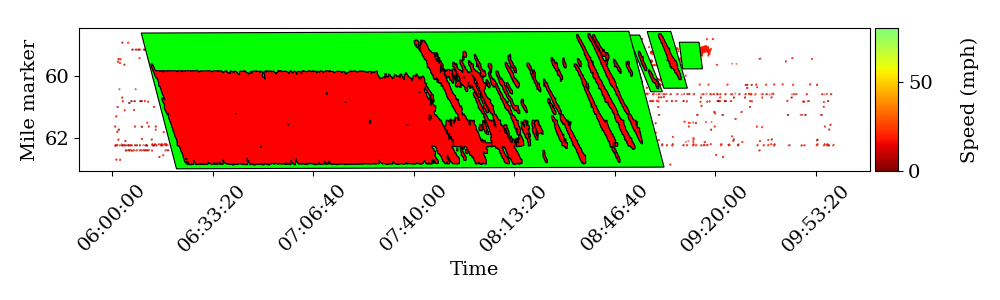

In [167]:
plt.close('all')

file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json",
]

file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
]

all_rows = []

for path in file_paths:
    
    if first_time:
        trajs_light, trajs_heavy, date = find_congestion_segments_dual(
            path,
            light_thresh=20,
            heavy_thresh=10,
        )
        
    distance_to_cover = 250
    time_to_cover = 3
    min_area = 10000
    min_area_hulls = 50000
    simplify_tolerance = 0
    union_bool = True

    simplified_polygons_light = create_congestion_zones(
        trajs_light,
        length=250,
        time_span=30,
        min_area=500000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=False,
        rectify=True,
        min_area_hulls=min_area_hulls,
        label="light_sub_20"
    )

    simplified_polygons_heavy = create_congestion_zones(
        trajs_heavy,
        length=500,
        time_span=5,
        min_area=50000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=True,
        min_area_hulls=min_area_hulls,
        buffer_distance=5,
        fill_gaps_distance=5,
        label="heavy_sub_10"
    )

    interactive_plot_congestion(
        trajs_light,
        polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        }
    )
    
    # Combine time + slope extraction in one pass to prevent mismatch
    time_lengths_light = []
    for rect in simplified_polygons_light:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_light.append(t)

    """time_lengths_heavy = []
    for rect in simplified_polygons_heavy:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_heavy.append(t)"""



    for t in time_lengths_light:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "light_sub_20",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })

    """for t in time_lengths_heavy:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "heavy_sub_10",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })"""

first_time = False

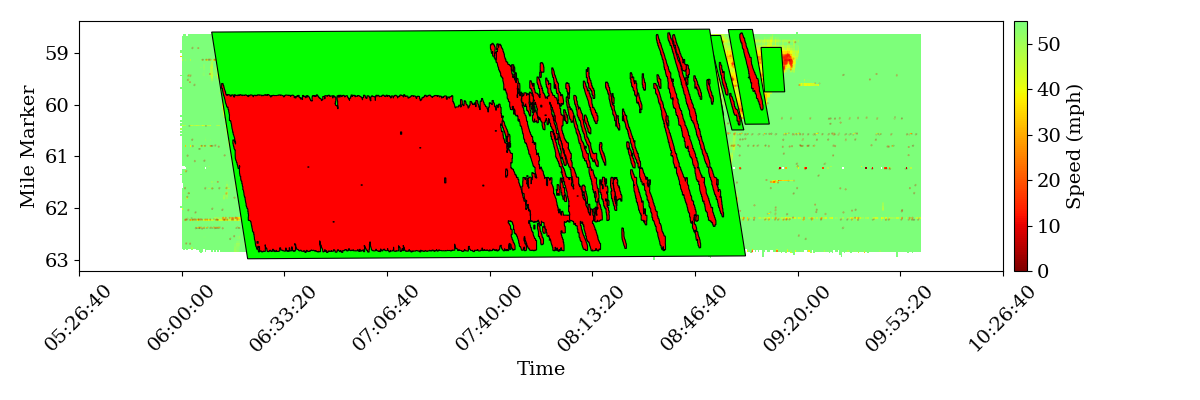

In [168]:
interactive_plot_congestion_with_edie(trajs_light, edie_grid=edie_cells,
                                       polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        })


In [177]:
print("Edie grid keys sample:", list(edie_cells.keys())[:5])
print("Edie grid x_bin range:", min(k[0] for k in edie_cells), max(k[0] for k in edie_cells))
print("Edie grid t_bin range:", min(k[1] for k in edie_cells), max(k[1] for k in edie_cells))


Edie grid keys sample: [(2041, 55634400), (1949, 55634399), (1949, 55634400), (1948, 55634400), (2048, 55634400)]
Edie grid x_bin range: 1934 2078
Edie grid t_bin range: 55634399 55634879


In [ ]:


def edie_cell_to_polygon(x_bin, t_bin, dx=160, dt=30):
    x0 = x_bin * dx / 5280
    x1 = (x_bin + 1) * dx / 5280
    t_start = t_bin * dt
    t_end = (t_bin + 1) * dt
    
    # The corners of the rectangle in (time, mile_marker) coordinates
    corners = [
        (t_start, x0),
        (t_start, x1),
        (t_end, x1),
        (t_end, x0),
        (t_start, x0),  # Close polygon by repeating the first point
    ]
    
    return Polygon(corners)


In [184]:
dx=160    # 160 feet ≈ ~50 meters
dt=30

edie_polygons = {}
for (x_bin, t_bin), cell in edie_cells.items():
    if cell["time"] == 0:
        continue
    edie_polygons[(x_bin, t_bin)] = edie_cell_to_polygon(x_bin, t_bin, dx, dt)


In [180]:


for i, congestion_poly in enumerate(simplified_polygons_heavy):
    overlap_cells = []
    for key, edie_poly in edie_polygons.items():
        if congestion_poly.intersects(edie_poly):
            overlap_cells.append(key)
    
    print(f"Polygon {i} overlaps {len(overlap_cells)} Edie cells")
    # You can now aggregate stats for these overlap_cells


Polygon 0 overlaps 0 Edie cells
Polygon 1 overlaps 0 Edie cells
Polygon 2 overlaps 0 Edie cells
Polygon 3 overlaps 0 Edie cells
Polygon 4 overlaps 0 Edie cells
Polygon 5 overlaps 0 Edie cells
Polygon 6 overlaps 0 Edie cells
Polygon 7 overlaps 0 Edie cells
Polygon 8 overlaps 0 Edie cells
Polygon 9 overlaps 0 Edie cells
Polygon 10 overlaps 0 Edie cells
Polygon 11 overlaps 0 Edie cells
Polygon 12 overlaps 0 Edie cells
Polygon 13 overlaps 0 Edie cells
Polygon 14 overlaps 0 Edie cells
Polygon 15 overlaps 0 Edie cells
Polygon 16 overlaps 0 Edie cells
Polygon 17 overlaps 0 Edie cells
Polygon 18 overlaps 0 Edie cells
Polygon 19 overlaps 0 Edie cells
Polygon 20 overlaps 0 Edie cells
Polygon 21 overlaps 0 Edie cells
Polygon 22 overlaps 0 Edie cells
Polygon 23 overlaps 0 Edie cells
Polygon 24 overlaps 0 Edie cells
Polygon 25 overlaps 0 Edie cells
Polygon 26 overlaps 0 Edie cells
Polygon 27 overlaps 0 Edie cells
Polygon 28 overlaps 0 Edie cells
Polygon 29 overlaps 0 Edie cells
Polygon 30 overlaps 

In [181]:
print("Congestion polygon 0 bounds:", simplified_polygons_light[0].bounds)
for i, ((x_bin, t_bin), poly) in enumerate(edie_polygons.items()):
    if i >= 5:
        break
    print(f"Edie cell polygon {i} bounds:", poly.bounds)


Congestion polygon 0 bounds: (1669043285.6408145, 310973.79809682036, 1669043746.5990143, 315511.2686511669)
Edie cell polygon 0 bounds: (1669032000.0, 61.84848484848485, 1669032030.0, 61.878787878787875)
Edie cell polygon 1 bounds: (1669031970.0, 59.06060606060606, 1669032000.0, 59.09090909090909)
Edie cell polygon 2 bounds: (1669032000.0, 59.06060606060606, 1669032030.0, 59.09090909090909)
Edie cell polygon 3 bounds: (1669032000.0, 59.03030303030303, 1669032030.0, 59.06060606060606)
Edie cell polygon 4 bounds: (1669032000.0, 62.06060606060606, 1669032030.0, 62.09090909090909)


In [ ]:


def convert_poly_y_to_miles(poly):
    coords = [(x, y / 5280) for x, y in poly.exterior.coords]
    return Polygon(coords)

simplified_polygons_light_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_light]
simplified_polygons_heavy_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_heavy]


In [183]:
print("Congestion polygon 0 bounds:", simplified_polygons_heavy_miles[0].bounds)
for i, ((x_bin, t_bin), poly) in enumerate(edie_polygons.items()):
    if i >= 5:
        break
    print(f"Edie cell polygon {i} bounds:", poly.bounds)


Congestion polygon 0 bounds: (1669038119.2800002, 58.827415273042185, 1669039564.3800004, 62.83557996869316)
Edie cell polygon 0 bounds: (1669032000.0, 61.84848484848485, 1669032030.0, 61.878787878787875)
Edie cell polygon 1 bounds: (1669031970.0, 59.06060606060606, 1669032000.0, 59.09090909090909)
Edie cell polygon 2 bounds: (1669032000.0, 59.06060606060606, 1669032030.0, 59.09090909090909)
Edie cell polygon 3 bounds: (1669032000.0, 59.03030303030303, 1669032030.0, 59.06060606060606)
Edie cell polygon 4 bounds: (1669032000.0, 62.06060606060606, 1669032030.0, 62.09090909090909)


In [ ]:


results = []

for i, congestion_poly in enumerate(simplified_polygons_heavy_miles):
    minx, _, _, _ = congestion_poly.bounds
    dt_start = datetime.fromtimestamp(minx, tz=timezone(timedelta(hours=-6)))  # Adjust timezone as needed
    time_label = dt_start.strftime('%H:%M:%S')
    
    overlap_cells = []
    for key, edie_poly in edie_polygons.items():
        if congestion_poly.intersects(edie_poly):
            overlap_cells.append(key)
    
    results.append((i, time_label, len(overlap_cells)))

# Sort descending by number of overlaps
results.sort(key=lambda x: x[2], reverse=True)

for i, time_label, count in results:
    print(f"Polygon {i} (start {time_label}) overlaps {count} Edie cells")


Polygon 4 (start 06:12:56) overlaps 17681 Edie cells
Polygon 0 (start 07:41:59) overlaps 1508 Edie cells
Polygon 44 (start 07:52:59) overlaps 1373 Edie cells
Polygon 111 (start 08:34:04) overlaps 560 Edie cells
Polygon 118 (start 08:37:49) overlaps 457 Edie cells
Polygon 114 (start 08:33:15) overlaps 450 Edie cells
Polygon 96 (start 08:28:38) overlaps 240 Edie cells
Polygon 127 (start 09:01:12) overlaps 220 Edie cells
Polygon 74 (start 08:07:09) overlaps 204 Edie cells
Polygon 72 (start 08:07:18) overlaps 161 Edie cells
Polygon 110 (start 08:25:43) overlaps 145 Edie cells
Polygon 99 (start 08:23:05) overlaps 119 Edie cells
Polygon 88 (start 08:15:42) overlaps 114 Edie cells
Polygon 81 (start 08:10:23) overlaps 102 Edie cells
Polygon 123 (start 08:39:24) overlaps 85 Edie cells
Polygon 85 (start 08:17:36) overlaps 73 Edie cells
Polygon 91 (start 08:20:05) overlaps 69 Edie cells
Polygon 42 (start 07:50:22) overlaps 68 Edie cells
Polygon 93 (start 08:19:13) overlaps 66 Edie cells
Polygon 1

In [ ]:
# Compute Edie metrics first
edie_metrics = compute_edie_metrics(edie_cells, dx=DX_FEET, dt=DT_SECONDS)

polygon_stats = []

for i, congestion_poly in enumerate(simplified_polygons_heavy_miles):
    min_time = congestion_poly.bounds[0]
    dt_start = datetime.fromtimestamp(min_time, tz=timezone(timedelta(hours=-6)))  # Adjust timezone if needed
    start_time_str = dt_start.strftime('%H:%M:%S')

    overlap_cells = [key for key, edie_poly in edie_polygons.items() if congestion_poly.intersects(edie_poly)]

    speeds = []
    flows = []
    densities = []

    for key in overlap_cells:
        metrics = edie_metrics.get(key)
        if metrics:
            speeds.append(metrics["speed_mph"])
            flows.append(metrics["flow_vph"])
            densities.append(metrics["density_vpm"])

    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    avg_flow = sum(flows) / len(flows) if flows else 0
    avg_density = sum(densities) / len(densities) if densities else 0

    polygon_stats.append({
        "index": i,
        "start_time": start_time_str,
        "overlap_count": len(overlap_cells),
        "avg_speed": avg_speed,
        "avg_flow": avg_flow,
        "avg_density": avg_density
    })

# Sort by overlap_count descending
polygon_stats.sort(key=lambda x: x["overlap_count"], reverse=True)

# Print sorted
for stat in polygon_stats:
    if stat["overlap_count"] == 0:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}) overlaps 0 Edie cells\n")
    else:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}):")
        print(f"  → Overlapping cells: {stat['overlap_count']}")
        print(f"  → Avg Speed: {stat['avg_speed']:.2f} mph")
        print(f"  → Avg Flow: {stat['avg_flow']:.2f} veh/hr")
        print(f"  → Avg Density: {stat['avg_density']:.2f} veh/mile\n")


Polygon 4 (start: 06:12:56):
  → Overlapping cells: 17681
  → Avg Speed: 10.85 mph
  → Avg Flow: 1240.36 veh/hr
  → Avg Density: 125.78 veh/mile

Polygon 0 (start: 07:41:59):
  → Overlapping cells: 1508
  → Avg Speed: 15.53 mph
  → Avg Flow: 1593.35 veh/hr
  → Avg Density: 112.10 veh/mile

Polygon 44 (start: 07:52:59):
  → Overlapping cells: 1373
  → Avg Speed: 17.45 mph
  → Avg Flow: 1683.01 veh/hr
  → Avg Density: 103.22 veh/mile

Polygon 111 (start: 08:34:04):
  → Overlapping cells: 560
  → Avg Speed: 19.60 mph
  → Avg Flow: 1626.44 veh/hr
  → Avg Density: 93.30 veh/mile

Polygon 118 (start: 08:37:49):
  → Overlapping cells: 457
  → Avg Speed: 21.50 mph
  → Avg Flow: 1720.55 veh/hr
  → Avg Density: 88.87 veh/mile

Polygon 114 (start: 08:33:15):
  → Overlapping cells: 450
  → Avg Speed: 22.16 mph
  → Avg Flow: 1744.77 veh/hr
  → Avg Density: 87.26 veh/mile

Polygon 96 (start: 08:28:38):
  → Overlapping cells: 240
  → Avg Speed: 19.20 mph
  → Avg Flow: 1636.65 veh/hr
  → Avg Density: 

In [186]:
print("Sample Edie Metrics Keys and their Polygons:")

edie_metrics = compute_edie_metrics(edie_cells, dx = 160, dt= 30)
sample_keys_metrics = list(edie_metrics.keys())[:5]
sample_keys_polygons = list(edie_polygons.keys())[:5]

for key in sample_keys_metrics:
    print(f"Key in edie_metrics: {key}")
    if key in edie_polygons:
        poly = edie_polygons[key]
        print(f"  Corresponding polygon bounds: {poly.bounds}")
    else:
        print("  No matching polygon found in edie_polygons")

print("\nSample Edie Polygon Keys and their Metrics:")

for key in sample_keys_polygons:
    print(f"Key in edie_polygons: {key}")
    if key in edie_metrics:
        metrics = edie_metrics[key]
        print(f"  Corresponding metrics: flow={metrics['flow_vph']:.2f}, speed={metrics['speed_mph']:.2f}, density={metrics['density_vpm']:.2f}")
    else:
        print("  No matching metrics found in edie_metrics")

# Check if keys match completely
keys_metrics = set(edie_metrics.keys())
keys_polygons = set(edie_polygons.keys())

missing_in_metrics = keys_polygons - keys_metrics
missing_in_polygons = keys_metrics - keys_polygons

print(f"\nKeys in edie_polygons but missing in edie_metrics: {missing_in_metrics}")
print(f"Keys in edie_metrics but missing in edie_polygons: {missing_in_polygons}")


Sample Edie Metrics Keys and their Polygons:
Key in edie_metrics: (2041, 55634400)
  Corresponding polygon bounds: (1669032000.0, 61.84848484848485, 1669032030.0, 61.878787878787875)
Key in edie_metrics: (1949, 55634399)
  Corresponding polygon bounds: (1669031970.0, 59.06060606060606, 1669032000.0, 59.09090909090909)
Key in edie_metrics: (1949, 55634400)
  Corresponding polygon bounds: (1669032000.0, 59.06060606060606, 1669032030.0, 59.09090909090909)
Key in edie_metrics: (1948, 55634400)
  Corresponding polygon bounds: (1669032000.0, 59.03030303030303, 1669032030.0, 59.06060606060606)
Key in edie_metrics: (2048, 55634400)
  Corresponding polygon bounds: (1669032000.0, 62.06060606060606, 1669032030.0, 62.09090909090909)

Sample Edie Polygon Keys and their Metrics:
Key in edie_polygons: (2041, 55634400)
  Corresponding metrics: flow=438.86, speed=67.39, density=6.51
Key in edie_polygons: (1949, 55634399)
  Corresponding metrics: flow=4.59, speed=34.74, density=0.13
Key in edie_polygons

In [ ]:
# Constants for Edie cell resolution
DX_FEET = 160  # ~50 meters
DT_SECONDS = 30  # 30-seconds time windows

edie_cells, date = compute_edie_stats(
    file_path="/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",  # replace with actual file path
    dx=DX_FEET,        # 160 feet ≈ ~50 meters
    dt=DT_SECONDS,         # 60 seconds time resolution
    direction=-1   # set the correct traffic direction
)

x_bins = {x for (x, _) in edie_cells.keys()}
t_bins = {t for (_, t) in edie_cells.keys()}

print(f"Number of Edie cells: {len(edie_cells)}")
print(f"  → Columns (space bins): {len(x_bins)}")
print(f"  → Rows (time bins): {len(t_bins)}")

Processed 10000 trajectories...
Processed 20000 trajectories...
Processed 30000 trajectories...
Processed 40000 trajectories...
Processed 50000 trajectories...
Processed 60000 trajectories...
Processed 70000 trajectories...
Processed 80000 trajectories...
Processed 90000 trajectories...
Processed 100000 trajectories...
Processed 110000 trajectories...
Processed 120000 trajectories...
Processed 130000 trajectories...
Processed 140000 trajectories...
Processed 150000 trajectories...
Processed 160000 trajectories...
Processed 170000 trajectories...
Processed 180000 trajectories...
Processed 190000 trajectories...
Processed 200000 trajectories...
Processed 210000 trajectories...
Processed 220000 trajectories...
Processed 230000 trajectories...
Processed 240000 trajectories...
Processed 250000 trajectories...
Processed 260000 trajectories...
Processed 270000 trajectories...
Processed 280000 trajectories...
Processed 290000 trajectories...
Processed 300000 trajectories...
Processed 310000 tr

In [ ]:


def convert_poly_y_to_miles(poly):
    coords = [(x, y / 5280) for x, y in poly.exterior.coords]
    return Polygon(coords)

simplified_polygons_light_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_light]
simplified_polygons_heavy_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_heavy]

In [ ]:
edie_polygons = {}
for (x_bin, t_bin), cell in edie_cells.items():
    if cell["time"] == 0:
        continue
    edie_polygons[(x_bin, t_bin)] = edie_cell_to_polygon(x_bin, t_bin, DX_FEET, DT_SECONDS)

In [ ]:
# Compute Edie metrics first
edie_metrics = compute_edie_metrics(edie_cells, dx=DX_FEET, dt=DT_SECONDS)

polygon_stats = []

for i, congestion_poly in enumerate(simplified_polygons_heavy_miles):
    min_time = congestion_poly.bounds[0]
    dt_start = datetime.fromtimestamp(min_time, tz=timezone(timedelta(hours=-6)))  # Adjust timezone if needed
    start_time_str = dt_start.strftime('%H:%M:%S')

    overlap_cells = [key for key, edie_poly in edie_polygons.items() if congestion_poly.intersects(edie_poly)]

    speeds = []
    flows = []
    densities = []

    for key in overlap_cells:
        metrics = edie_metrics.get(key)
        if metrics:
            speeds.append(metrics["speed_mph"])
            flows.append(metrics["flow_vph"])
            densities.append(metrics["density_vpm"])

    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    avg_flow = sum(flows) / len(flows) if flows else 0
    avg_density = sum(densities) / len(densities) if densities else 0

    polygon_stats.append({
        "index": i,
        "start_time": start_time_str,
        "overlap_count": len(overlap_cells),
        "avg_speed": avg_speed,
        "avg_flow": avg_flow,
        "avg_density": avg_density
    })

# Sort by overlap_count descending
polygon_stats.sort(key=lambda x: x["overlap_count"], reverse=True)

# Print sorted
for stat in polygon_stats:
    if stat["overlap_count"] == 0:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}) overlaps 0 Edie cells\n")
    else:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}):")
        print(f"  → Overlapping cells: {stat['overlap_count']}")
        print(f"  → Avg Speed: {stat['avg_speed']:.2f} mph")
        print(f"  → Avg Flow: {stat['avg_flow']:.2f} veh/hr")
        print(f"  → Avg Density: {stat['avg_density']:.2f} veh/mile\n")


Polygon 4 (start: 06:12:56):
  → Overlapping cells: 17681
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 0 (start: 07:41:59):
  → Overlapping cells: 1508
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 44 (start: 07:52:59):
  → Overlapping cells: 1373
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 111 (start: 08:34:04):
  → Overlapping cells: 560
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 118 (start: 08:37:49):
  → Overlapping cells: 457
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 114 (start: 08:33:15):
  → Overlapping cells: 450
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 96 (start: 08:28:38):
  → Overlapping cells: 240
  → Avg Speed: 0.00 mph
  → Avg Flow: 0.00 veh/hr
  → Avg Density: 0.00 veh/mile

Polygon 127 (start: 09

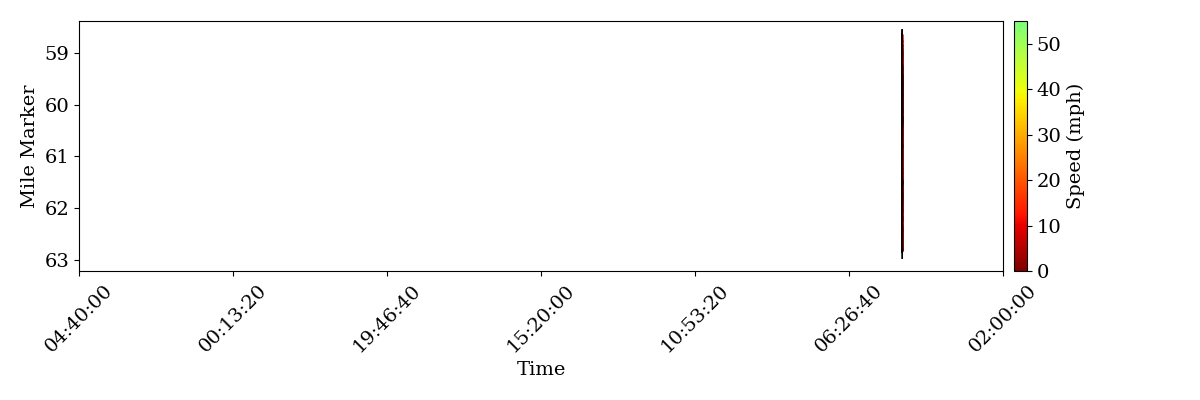

In [140]:
interactive_plot_congestion_with_edie(trajs_light, edie_grid=edie_cells,
                                       polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        })